# Dynamical MHA with Differentiable Readout

We made some nice dynamical MHAs back in the [Chemical Computation](https://github.com/amanb2000/Chemical_Computation/blob/main/notebooks/01%20Dynamical%20MHA.ipynb) days. 
Unfortunately, the "readout map" that mapped from the state tensor $\mathbf X \in \mathbb R^{N \times d}$ to a bitmap/image of the space was just a matplotlib scatter plot. 

That's a major problem if we want to train these things to self assemble. How do we compute the loss between the current state configuration and the goal state? 

Let's take inspiration from [Sebastian League](https://youtu.be/X-iSQQgOd1A?si=I84x4XhSGoASENr5) and make a function to map from "agent positions" (each of the $N$ token representations for us) to a bitmap with a Gaussian rendered at that position. 

We can start by re-making the dynamical MHA from Chemical Computation: 

In [1]:
## Import box
import numpy as np 
import matplotlib.pyplot as plt

import torch 
from torch import nn

from tqdm import tqdm
import os
import glob 
import cv2

/home/aman/Transformer_Phase_Space/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda


In [3]:
## Setting up the MHA 
embed_dim = 5   # Key and query dimension expected in the input.
key_dim = 5     # Expected dimension of the keys + queries
val_dim = 5     # Expected dimension of the 
num_heads = 1   # Number of heads in the MHA.
multihead_attn = nn.MultiheadAttention(embed_dim, num_heads, kdim=key_dim, vdim=val_dim, bias=False).to(DEVICE) # value/outpu

In [4]:
## Setting up the state matrix 
N = 100             # Number of particles/sequence length
num_batch = 1

state_matrix = torch.rand(N, num_batch, val_dim).to(DEVICE) # uniform [0, 1]
state_matrix.shape

torch.Size([100, 1, 5])

In [5]:
dx, attn_map = multihead_attn(state_matrix, state_matrix, state_matrix)
print("mha_out[0] shape: ", dx.shape, "\t(Output values, shape: [N=100, batch=1, embed_dim=5])")
print("mha_out[1] shape: ", attn_map.shape, "\t(Attention map, shape: [batch=1, N=100, N=100])")

mha_out[0] shape:  torch.Size([100, 1, 5]) 	(Output values, shape: [N=100, batch=1, embed_dim=5])
mha_out[1] shape:  torch.Size([1, 100, 100]) 	(Attention map, shape: [batch=1, N=100, N=100])


In [6]:
## Before moving on, let's get a sense of the means/variance of the input vs. output
sm_std, sm_mean = torch.std_mean(state_matrix)
dx_std, dx_mean = torch.std_mean(dx.detach())
print("Input state matrix: \t", sm_mean, " +/- ", sm_std)
print("MHA output matrix: \t", dx_mean, " +/- ", dx_std)

Input state matrix: 	 tensor(0.5076, device='cuda:0')  +/-  tensor(0.2885, device='cuda:0')
MHA output matrix: 	 tensor(-0.0064, device='cuda:0')  +/-  tensor(0.1543, device='cuda:0')


## Run a Simulation

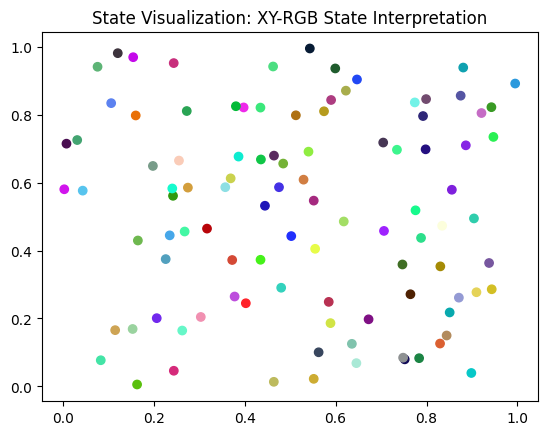

In [7]:
# TODO: Make a differentiable bitmap renderer
def visualize_state_matrix(X_, title='State Visualization: XY-RGB State Interpretation', savename='../figs/test.png', show=False):
    # make the directories leading to savename if they don't exist 
    os.makedirs(os.path.dirname(savename), exist_ok=True)
    
    X = X_.detach().to('cpu')
    XY = X[:, :2]
    RGB = X[:,2:5]
    plt.scatter(XY[:,0], XY[:,1], c=RGB)
    plt.title(title)
    plt.savefig(savename)
    if show:
        plt.show()
    plt.close()

visualize_state_matrix(state_matrix[:,0,:], show=True)

In [8]:
## Define a for loop that iterates thru some number of state updates
num_iters = 1000
dt = 0.2
noise_factor = 0.005
fig_folder='anim03'

In [9]:
for i in tqdm(range(num_iters)): 
    dx, _ = multihead_attn(state_matrix, state_matrix, state_matrix)
    dxy = dx[:,:,0:2]

    # noise up the dxy 
    noise = torch.randn_like(dxy).to(DEVICE)*noise_factor  # 0 mean, variance 1
    dxy += noise

    # let's try normalizing dxy -- right now the variance is super tight.
    dxy_std, dxy_mean = torch.std_mean(dxy)
    dxy = dxy - dxy_mean
    dxy = dxy/dxy_std

    dxyrgb = torch.zeros(dx.shape).to(DEVICE) 
    dxyrgb[:,:,0:2] = dxy

    state_matrix += dxyrgb*dt
    

    visualize_state_matrix(state_matrix[:,0,:], savename=f'../figs/{fig_folder}/frame_{str(i).zfill(3)}.png')


100%|██████████| 1000/1000 [01:05<00:00, 15.24it/s]


##  Construct Video

In [10]:
png_path = f'../figs/{fig_folder}/*.png'
img_array = []
for filename in sorted(glob.glob(png_path)): 
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width, height)
    img_array.append(img)


In [11]:
out = cv2.VideoWriter(f'../figs/{fig_folder}.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [12]:
# show video in jupyter notebook 
from IPython.display import Video
Video(f'../figs/{fig_folder}.mp4', embed=True)

## Differentiable Frame Renderer

In [13]:
# X = torch.rand(21, 5) # 21 particles, 5 dimensional state
# X

In [14]:
# X[:, 2:5]

In [8]:
def RGB_render_particles_to_bitmap(X, x_res, y_res, sigma=1.0, scale_sigma=False):
    """
    Renders colored particles as Gaussian distributions on an RGB bitmap.

    Args:
        X (torch.Tensor): A tensor of shape [N, d] where d >= 5, with the first two dimensions
                          representing particle positions and the next three dimensions
                          representing RGB colors of each particle.
        x_res (int): The resolution of the bitmap along the x-axis.
        y_res (int): The resolution of the bitmap along the y-axis.
        sigma (float): The standard deviation of the Gaussians in pixels.
        scale_sigma (bool): If True, scales sigma by the same factor as positions.

    Returns:
        torch.Tensor: An RGB bitmap of shape [x_res, y_res, 3] with rendered Gaussian
                      distributions of particles, each colored according to its RGB value.
    """
    # Initialize an empty RGB bitmap of shape [y_res, x_res, 3]
    rgb_bitmap = torch.zeros((y_res, x_res, 3))

    # Scale particle positions to fit within [-1, 1]
    min_pos = torch.min(X[:, 0:2], dim=0)[0]
    max_pos = torch.max(X[:, 0:2], dim=0)[0]
    scale_factor = torch.max(max_pos - min_pos) / 2
    scaled_X = (X[:, 0:2] - (min_pos + scale_factor)) / scale_factor

    # Optionally scale sigma
    if scale_sigma:
        sigma *= scale_factor

    # Generate a meshgrid for the bitmap coordinates
    x = torch.linspace(-1, 1, steps=x_res)
    y = torch.linspace(-1, 1, steps=y_res)
    xx, yy = torch.meshgrid(x, y, indexing="ij")

    # For each particle, add its colored Gaussian distribution to the RGB bitmap
    for i in range(X.shape[0]):
        # Calculate Gaussian distribution
        gx = torch.exp(-((xx - scaled_X[i, 0]) ** 2) / (2 * sigma ** 2))
        gy = torch.exp(-((yy - scaled_X[i, 1]) ** 2) / (2 * sigma ** 2))
        gaussian = gx * gy

        # Apply color to Gaussian
        for channel in range(3):
            rgb_bitmap[:, :, channel] += gaussian * X[i, channel + 2]

    # Normalize the RGB bitmap so the maximum Gaussian value is 1 for each channel
    max_val = torch.max(rgb_bitmap.view(-1, 3), dim=0)[0]
    rgb_bitmap /= max_val.clamp(min=1)  # Avoid division by zero

    return rgb_bitmap

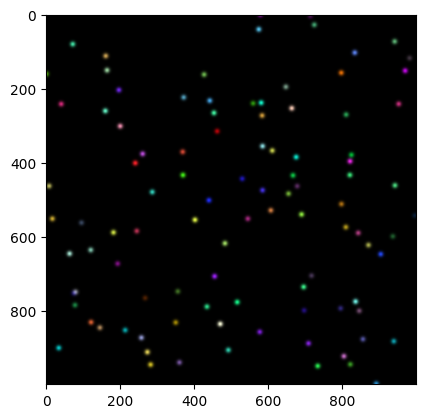

In [9]:
x_res = 1000
y_res = 1000

bitmap = RGB_render_particles_to_bitmap(state_matrix[:, 0, :].detach().to('cpu'), x_res, y_res, sigma=0.01, scale_sigma=False)
plt.imshow(bitmap.numpy())

## Gaussian-Rendered Simulation

In [10]:
## Setting up the MHA 
embed_dim = 5   # Key and query dimension expected in the input.
key_dim = 5     # Expected dimension of the keys + queries
val_dim = 5     # Expected dimension of the 
num_heads = 1   # Number of heads in the MHA.
multihead_attn = nn.MultiheadAttention(embed_dim, num_heads, kdim=key_dim, vdim=val_dim, bias=False).to(DEVICE) # value/output

## Setting up the state matrix 
N = 100             # Number of particles/sequence length
num_batch = 1

state_matrix = torch.rand(N, num_batch, val_dim).to(DEVICE) # uniform [0, 1]
state_matrix.shape

## Define a for loop that iterates thru some number of state updates
num_iters = 1000
dt = 0.2
noise_factor = 0.005
fig_folder='anim04'

x_res = 1000
y_res = 1000

In [11]:
def visualize_state_matrix(X_, title='State Visualization: XY-RGB State Interpretation', savename='../figs/test.png', show=False):
    # make the directories leading to savename if they don't exist 
    os.makedirs(os.path.dirname(savename), exist_ok=True)
    
    X = X_.detach().cpu()
    bitmap = RGB_render_particles_to_bitmap(X, x_res, y_res, sigma=0.01, scale_sigma=False)
    plt.imshow(bitmap.numpy())
    plt.title(title)
    plt.savefig(savename)
    if show:
        plt.show()
    plt.close()

    

In [12]:
for i in tqdm(range(num_iters)): 
    dx, _ = multihead_attn(state_matrix, state_matrix, state_matrix)
    dxy = dx[:,:,0:2]

    # noise up the dxy 
    noise = torch.randn_like(dxy).to(DEVICE)*noise_factor  # 0 mean, variance 1
    dxy += noise

    # let's try normalizing dxy -- right now the variance is super tight.
    dxy_std, dxy_mean = torch.std_mean(dxy)
    dxy = dxy - dxy_mean
    dxy = dxy/dxy_std

    dxyrgb = torch.zeros(dx.shape).to(DEVICE) 
    dxyrgb[:,:,0:2] = dxy

    state_matrix += dxyrgb*dt
    
    # savename = f'../figs/{fig_folder}/frame_{str(i).zfill(3)}.png'
    visualize_state_matrix(state_matrix[:,0,:], savename=f'../figs/{fig_folder}/frame_{str(i).zfill(3)}.png')


 35%|███▌      | 350/1000 [04:12<07:42,  1.41it/s]